<a href="https://www.kaggle.com/code/celalngr/ps-s5e4-eda-prediction?scriptVersionId=234698946" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Podcast Listening Time EDA&Prediction

#### In the world of podcasts, does duration truly matter? Do listeners prefer long marathons or short sprints?


## 📘 Analysis Headings

1. [Importing Required Libraries](#1)
2. [Dataset Overview](#2)
3. [Data Import](#3)
4. [Data Preprocessing](#4)
5.  [Data Analysis (EDA)](#5)
6.  [Correlation Heatmap](#6)
7. [Feature Engineering](#7)
   - [Feature Creation](#7.1)
   - [Feature Scaling](#7.2)
    
     
8. [Modeling](#8)
   - [Linear Regression](#8.1)
   - [XGBoost Modeling](#8.2)

<a id="1"></a>
## Importing Required Libraries

In [6]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


<a id="2"></a>
## Dataset Overview

1. **id**: Unique identifier for each record.
2. **Podcast_Name**: The name of the podcast.
3. **Episode_Title**: The title of the episode.
4. **Episode_Length_minutes**: Duration of the episode in minutes.
5. **Genre**: The genre of the podcast (e.g., Comedy, Health, Technology, etc.).
6. **Host_Popularity_percentage**: The popularity of the podcast host, represented as a percentage.
7. **Publication_Day**: The day of the week when the episode was published.
8. **Publication_Time**: The time of day the episode was released (e.g., Morning, Afternoon, Evening, Night).
9. **Guest_Popularity_percentage**: The popularity of the guest(s) in the episode, represented as a percentage.
10. **Number_of_Ads**: The number of advertisements in the episode.
11. **Episode_Sentiment**: The sentiment of the episode (e.g., Positive, Negative, Neutral).
12. **Listening_Time_minutes**: The total time in minutes that the episode was listened to by users.


<a id="3"></a>
## Data Import

In [7]:
train = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")

In [3]:
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [4]:
train.shape

(750000, 12)

In [5]:
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [6]:
test.shape

(250000, 11)

<a id="4"></a>
## Data Preprocessing

In [7]:
train.isnull().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [8]:
test.isnull().sum()

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

In [9]:
# Eksik verileri model tahminiyle doldurma

features = ["Host_Popularity_percentage", "Listening_Time_minutes"]

train_data_episode_length = train.dropna(subset=["Episode_Length_minutes"])
test_data_episode_length = train[train["Episode_Length_minutes"].isna()]

lgbm_episode_length = LGBMRegressor()
lgbm_episode_length.fit(train_data_episode_length[features], train_data_episode_length["Episode_Length_minutes"])

predictions_episode_length = lgbm_episode_length.predict(test_data_episode_length[features])
train.loc[train["Episode_Length_minutes"].isna(), "Episode_Length_minutes"] = predictions_episode_length

train_data_guest_popularity = train.dropna(subset=["Guest_Popularity_percentage"])
test_data_guest_popularity = train[train["Guest_Popularity_percentage"].isna()]

lgbm_guest_popularity = LGBMRegressor()
lgbm_guest_popularity.fit(train_data_guest_popularity[features], train_data_guest_popularity["Guest_Popularity_percentage"])

predictions_guest_popularity = lgbm_guest_popularity.predict(test_data_guest_popularity[features])
train.loc[train["Guest_Popularity_percentage"].isna(), "Guest_Popularity_percentage"] = predictions_guest_popularity

print("Train Eksik Veriler:")
print(train.isna().sum())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 662907, number of used features: 2
[LightGBM] [Info] Start training from score 64.504738
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 603970, number of used features: 2
[LightGBM] [Info] Start training from score 52.236449
Train Eksik Veriler:
id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    

In [10]:
ads_median = train["Number_of_Ads"].median()

train["Number_of_Ads"].fillna(ads_median, inplace=True)

print("Train Eksik Veriler:")
print(train.isna().sum())

Train Eksik Veriler:


<ipython-input-10-a514b7a76c04>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["Number_of_Ads"].fillna(ads_median, inplace=True)


id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64


In [11]:
features = ["Number_of_Ads", "Host_Popularity_percentage"]

test_data_episode_length = test[test["Episode_Length_minutes"].isna()]
lgbm_episode_length = LGBMRegressor()
lgbm_episode_length.fit(train[features], train["Episode_Length_minutes"])
predictions_episode_length_test = lgbm_episode_length.predict(test_data_episode_length[features])
test.loc[test["Episode_Length_minutes"].isna(), "Episode_Length_minutes"] = predictions_episode_length_test

test_data_guest_popularity = test[test["Guest_Popularity_percentage"].isna()]
lgbm_guest_popularity = LGBMRegressor()
lgbm_guest_popularity.fit(train[features], train["Guest_Popularity_percentage"])
predictions_guest_popularity_test = lgbm_guest_popularity.predict(test_data_guest_popularity[features])
test.loc[test["Guest_Popularity_percentage"].isna(), "Guest_Popularity_percentage"] = predictions_guest_popularity_test

print("Test Eksik Veriler:")
print(test.isna().sum())


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 2
[LightGBM] [Info] Start training from score 64.183747
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 2
[LightGBM] [Info] Start training from score 52.218068
Test Eksik Veriler:
id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Hos

In [12]:
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
               'Friday': 4, 'Saturday': 5, 'Sunday': 6}

time_mapping = {'Morning': 9, 'Afternoon': 14, 'Evening': 19, 'Night': 23}

sentiment_mapping = {'Negative': 1, 'Neutral': 2, 'Positive': 3}

train['Publication_Day_num'] = train['Publication_Day'].map(day_mapping)
train['Publication_Time_num'] = train['Publication_Time'].map(time_mapping)
train['Episode_Sentiment_num'] = train['Episode_Sentiment'].map(sentiment_mapping)

test['Publication_Day_num'] = test['Publication_Day'].map(day_mapping)
test['Publication_Time_num'] = test['Publication_Time'].map(time_mapping)
test['Episode_Sentiment_num'] = test['Episode_Sentiment'].map(sentiment_mapping)

<a id = '5'></a>
## Data Analysis

In [13]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Publication_Day_num,Publication_Time_num,Episode_Sentiment_num
0,0,Mystery Matters,Episode 98,48.06746,True Crime,74.81,Thursday,Night,53.805256,0.0,Positive,31.41998,3,23,3
1,1,Joke Junction,Episode 26,119.80000,Comedy,66.95,Saturday,Afternoon,75.950000,2.0,Negative,88.01241,5,14,1
2,2,Study Sessions,Episode 16,73.90000,Education,69.97,Tuesday,Evening,8.970000,0.0,Negative,44.92531,1,19,1
3,3,Digital Digest,Episode 45,67.17000,Technology,57.22,Monday,Morning,78.700000,2.0,Positive,46.27824,0,9,3
4,4,Mind & Body,Episode 86,110.51000,Health,80.07,Monday,Afternoon,58.680000,3.0,Neutral,75.61031,0,14,2


In [14]:
genre_count = train["Genre"].value_counts()
genre_count

Genre
Sports        87606
Technology    86256
True Crime    85059
Lifestyle     82461
Comedy        81453
Business      80521
Health        71416
News          63385
Music         62743
Education     49100
Name: count, dtype: int64

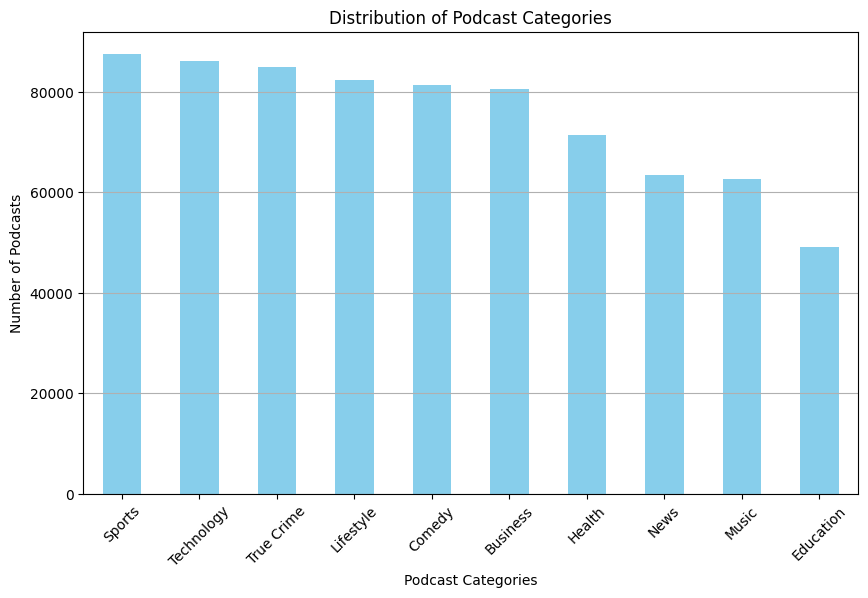

In [15]:
plt.figure(figsize =(10,6))
genre_count.plot(kind = 'bar', color="skyblue")
plt.title("Distribution of Podcast Categories")
plt.xlabel("Podcast Categories")
plt.ylabel("Number of Podcasts")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

* The distribution of podcast categories shows that Sports and Technology have the most content. The scarcity in the Education category is noteworthy. Does this situation represent a growth opportunity in the education field or a reflection of the current demand? It's an important indicator for content strategies.

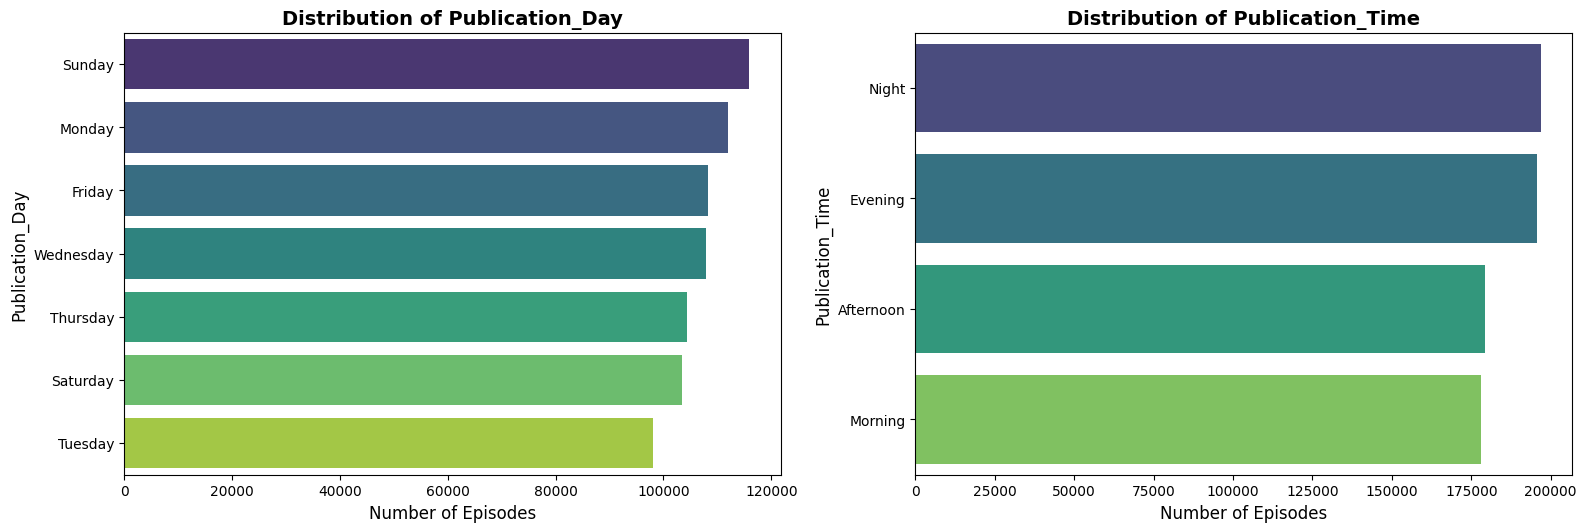

In [16]:
categorical_features = ["Publication_Day", "Publication_Time"]

plt.figure(figsize=(16, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=train, y=feature, order=train[feature].value_counts().index, palette="viridis")
    plt.title(f"Distribution of {feature}", fontsize=14, fontweight='bold')
    plt.xlabel("Number of Episodes", fontsize=12)
    plt.ylabel(feature, fontsize=12)
plt.tight_layout()
plt.show()

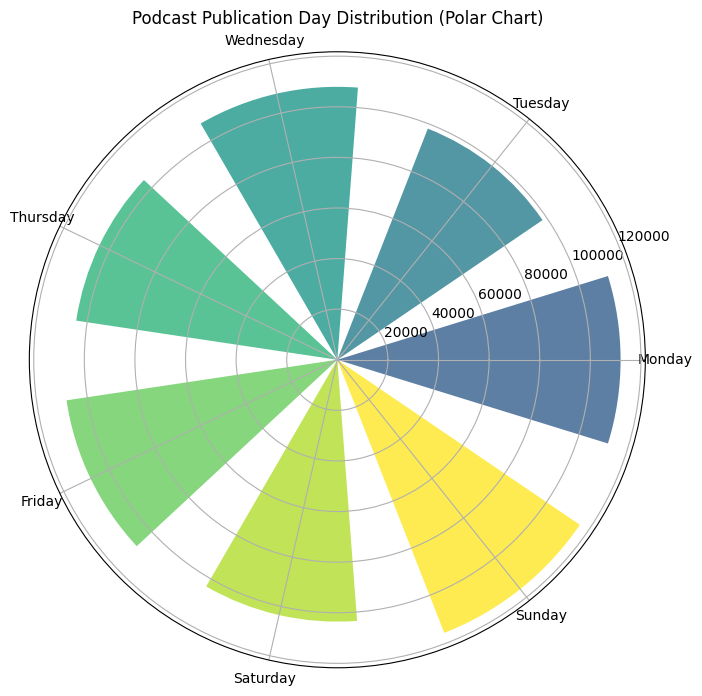

In [17]:
# Haftanın günlerini sıralayarak sayma
day_counts = train['Publication_Day'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)

# Verileri kutupsal koordinatlara çevirmek için açıları belirleme
angles = np.linspace(0, 2 * np.pi, len(day_counts), endpoint=False)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
bars = ax.bar(angles, day_counts.values, width=0.6, color=plt.cm.viridis(np.linspace(0.3, 1, len(day_counts))), alpha=0.8)
ax.set_xticks(angles)
ax.set_xticklabels(day_counts.index)
ax.set_title("Podcast Publication Day Distribution (Polar Chart)", pad=20)
plt.show()

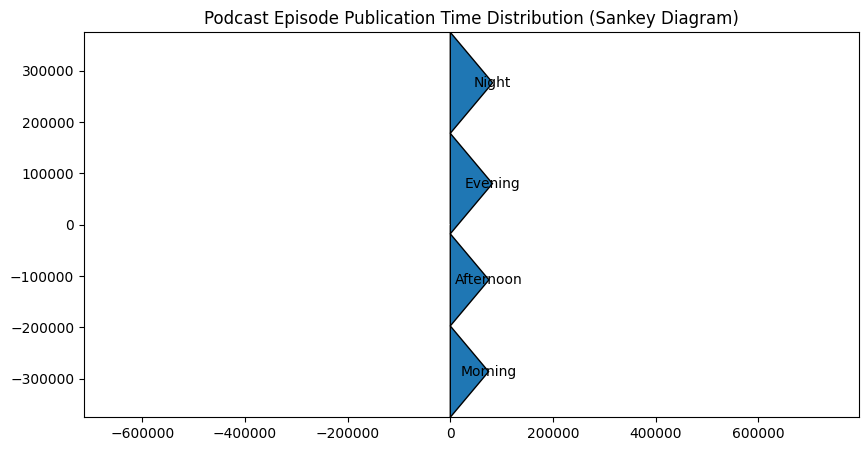

In [18]:
# Yayın zamanlarının dağılımını al
time_counts = train['Publication_Time'].value_counts()
# Sankey için giriş-çıkış değerleri oluştur
labels = list(time_counts.index)  # Sabah, öğleden sonra, akşam gibi etiketler
flows = list(time_counts.values)  # Her zaman diliminde yayınlanan bölüm sayısı
flows = [-x for x in flows]  # Girişleri negatif yaparak akışı göstermek için
fig, ax = plt.subplots(figsize=(10, 5))
sankey = Sankey(ax=ax, unit=None)
sankey.add(flows=flows, labels=labels, orientations=[0] * len(flows))  
sankey.finish()
ax.set_title("Podcast Episode Publication Time Distribution (Sankey Diagram)")
plt.show()

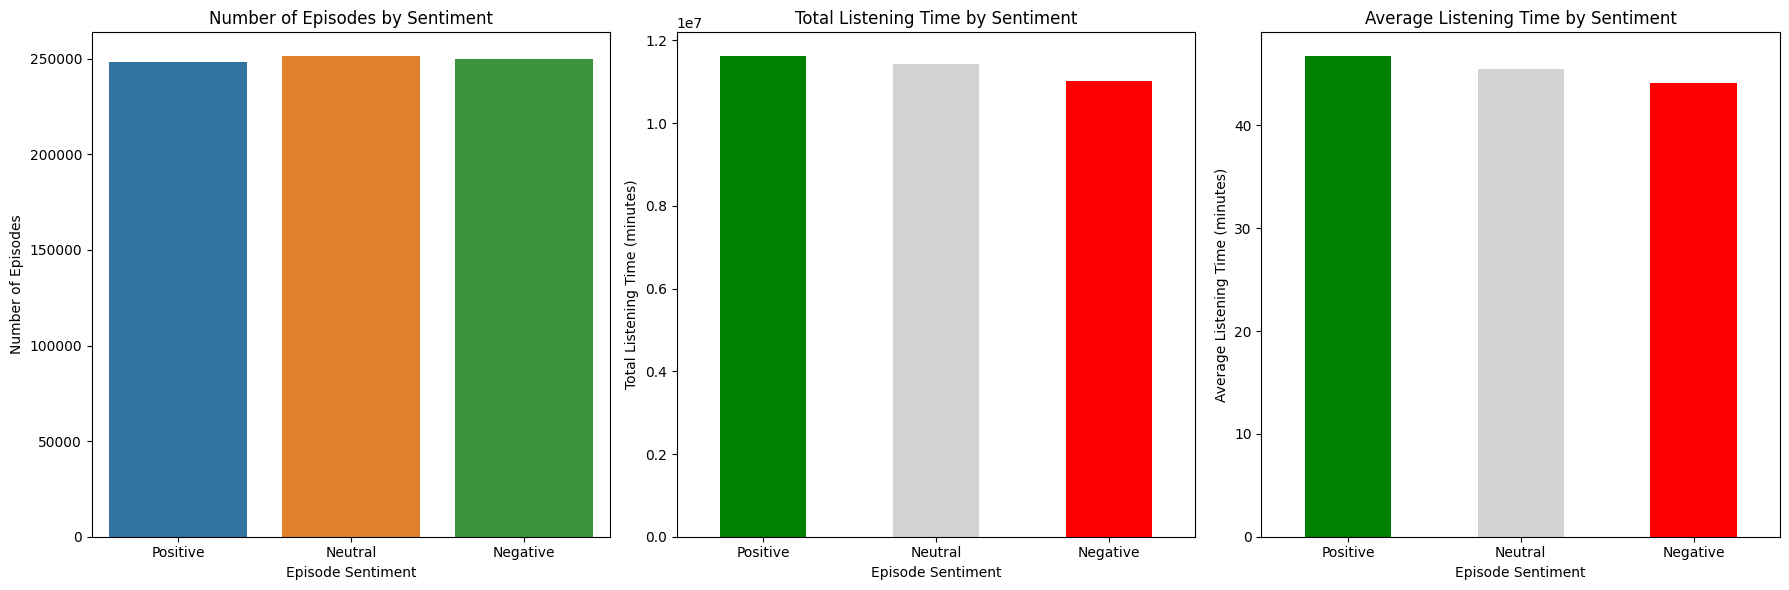

In [19]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.countplot(data=train, x='Episode_Sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title('Number of Episodes by Sentiment')
plt.xlabel('Episode Sentiment')
plt.ylabel('Number of Episodes')

plt.subplot(1, 3, 2)
sentiment_listening_time = train.groupby('Episode_Sentiment')['Listening_Time_minutes'].sum().sort_values(ascending=False)
sentiment_listening_time.plot(kind='bar', color=['green', 'lightgray', 'red'])
plt.title('Total Listening Time by Sentiment')
plt.xlabel('Episode Sentiment')
plt.ylabel('Total Listening Time (minutes)')
plt.xticks(rotation=0)

plt.subplot(1, 3, 3)
sentiment_avg_listening_time = train.groupby('Episode_Sentiment')['Listening_Time_minutes'].mean().sort_values(ascending=False)
sentiment_avg_listening_time.plot(kind='bar', color=['green', 'lightgray', 'red'])
plt.title('Average Listening Time by Sentiment')
plt.xlabel('Episode Sentiment')
plt.ylabel('Average Listening Time (minutes)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

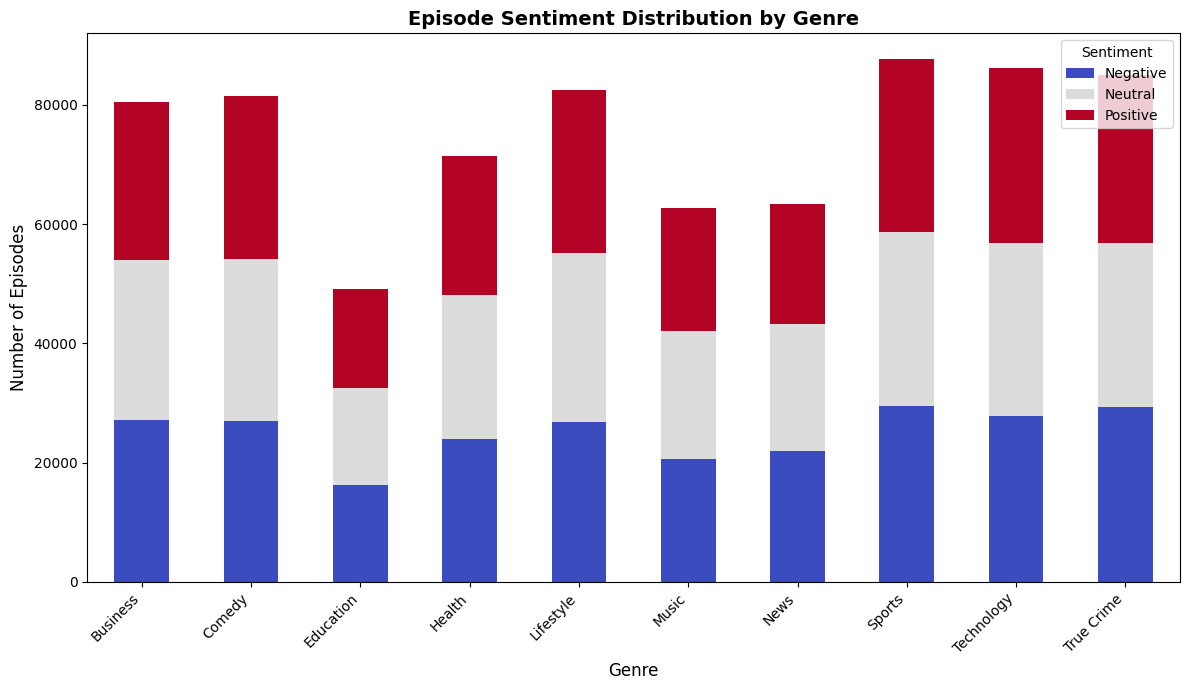

In [20]:
#Genre ve Episode_Sentiment ilişkisi
genre_sentiment = train.groupby(['Genre', 'Episode_Sentiment']).size().unstack(fill_value=0)
genre_sentiment.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='coolwarm')
plt.title("Episode Sentiment Distribution by Genre", fontsize=14, fontweight='bold')
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number of Episodes", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [21]:
top_10_genel = train[['Podcast_Name', 'Host_Popularity_percentage','Episode_Title', 'Genre', 'Episode_Sentiment']].sort_values(by='Host_Popularity_percentage', ascending=False).head(10)
top_10_genel

,Podcast_Name,Host_Popularity_percentage,Episode_Title,Genre,Episode_Sentiment
538582,Mind & Body,119.46,Episode 31,Health,Negative
343982,Current Affairs,118.93,Episode 17,News,Positive
79078,Current Affairs,118.73,Episode 17,News,Positive
226171,Comedy Corner,118.69,Episode 23,Comedy,Positive
23925,Fitness First,117.76,Episode 79,Health,Positive
183757,Fitness First,117.76,Episode 79,Health,Positive
599478,Lifestyle Lounge,117.14,Episode 15,Lifestyle,Positive
369147,Lifestyle Lounge,117.14,Episode 90,Lifestyle,Positive
459018,Joke Junction,117.14,Episode 70,Comedy,Positive
176422,Lifestyle Lounge,117.14,Episode 70,Lifestyle,Positive


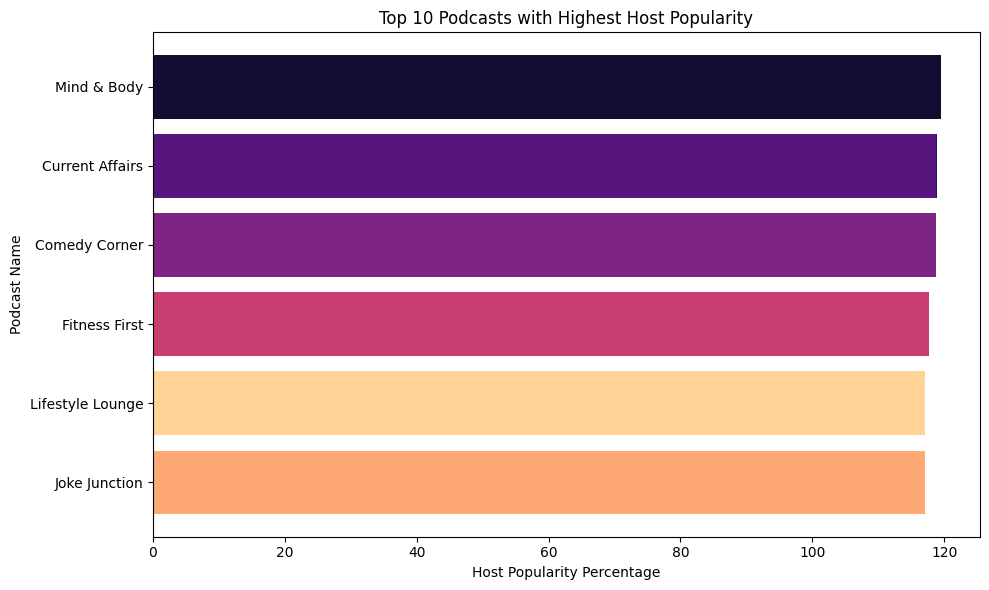

In [22]:

top_10_hosts = train[['Podcast_Name', 'Host_Popularity_percentage']].sort_values(by='Host_Popularity_percentage', ascending=False).head(10)

new_colors = sns.color_palette("magma", len(top_10_hosts))

plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_hosts['Podcast_Name'], top_10_hosts['Host_Popularity_percentage'], color=new_colors)

plt.title('Top 10 Podcasts with Highest Host Popularity')
plt.xlabel('Host Popularity Percentage')
plt.ylabel('Podcast Name')
plt.gca().invert_yaxis()
plt.tight_layout() 
plt.show()


When we examine the top 10 podcasts with the highest host popularity, we see that the Health, News, Comedy, and Lifestyle genres stand out. Notably, 'Mind & Body' has the highest popularity, while 'Current Affairs', 'Fitness First', and 'Lifestyle Lounge' are also represented multiple times in the list. This suggests that there may be more hosts favored by listeners in these genres.

In [23]:
crime_podcasts = train[train['Genre'] == 'True Crime']
crime_sentiment_counts = crime_podcasts['Episode_Sentiment'].value_counts()
crime_sentiment_counts.head()

Episode_Sentiment
Negative    29239
Positive    28176
Neutral     27644
Name: count, dtype: int64

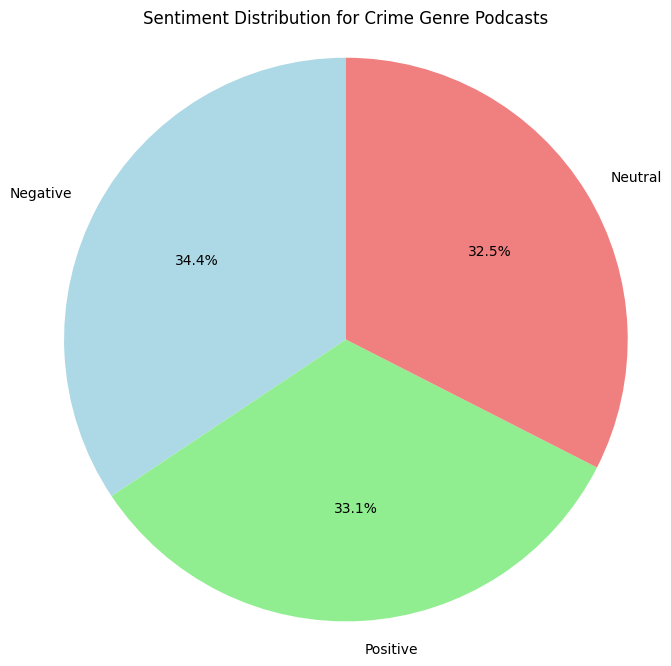

In [24]:
## 
crime_podcasts = train[train['Genre'] == 'True Crime']

crime_sentiment_counts = crime_podcasts['Episode_Sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(crime_sentiment_counts, labels=crime_sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Sentiment Distribution for Crime Genre Podcasts')
plt.axis('equal')  
plt.show()


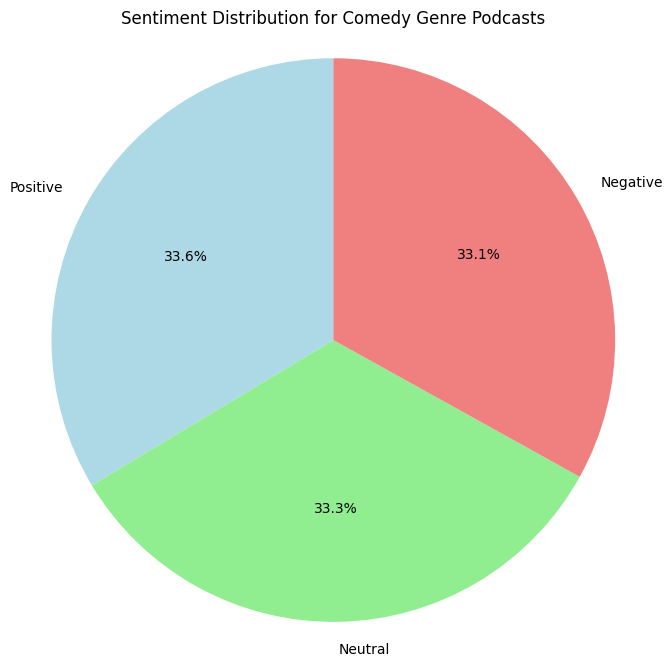

In [25]:

comedy_podcasts = train[train['Genre'] == 'Comedy']


comedy_sentiment_counts = comedy_podcasts['Episode_Sentiment'].value_counts()


plt.figure(figsize=(8, 8))
plt.pie(comedy_sentiment_counts, labels=comedy_sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Sentiment Distribution for Comedy Genre Podcasts')
plt.axis('equal')  
plt.show()


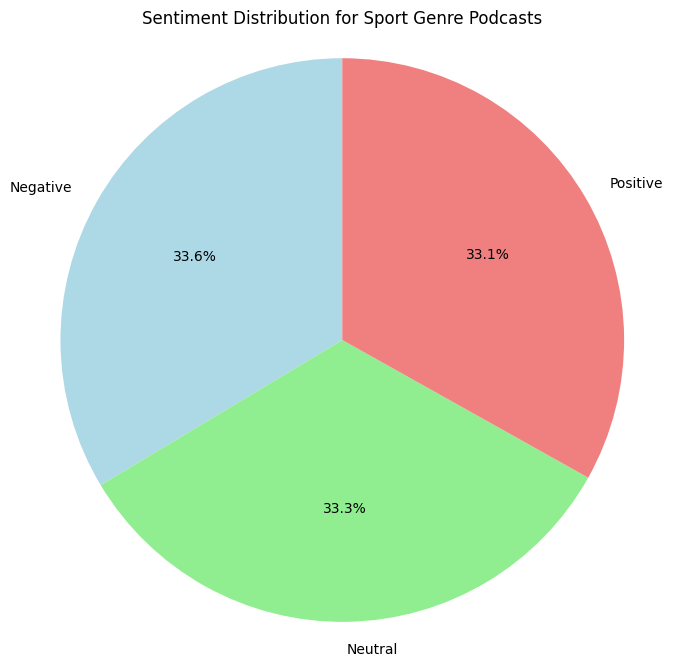

In [26]:

sport_podcasts = train[train['Genre'] == 'Sports']


sport_sentiment_counts = sport_podcasts['Episode_Sentiment'].value_counts()


plt.figure(figsize=(8, 8))
plt.pie(sport_sentiment_counts, labels=sport_sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Sentiment Distribution for Sport Genre Podcasts')
plt.axis('equal')  
plt.show()


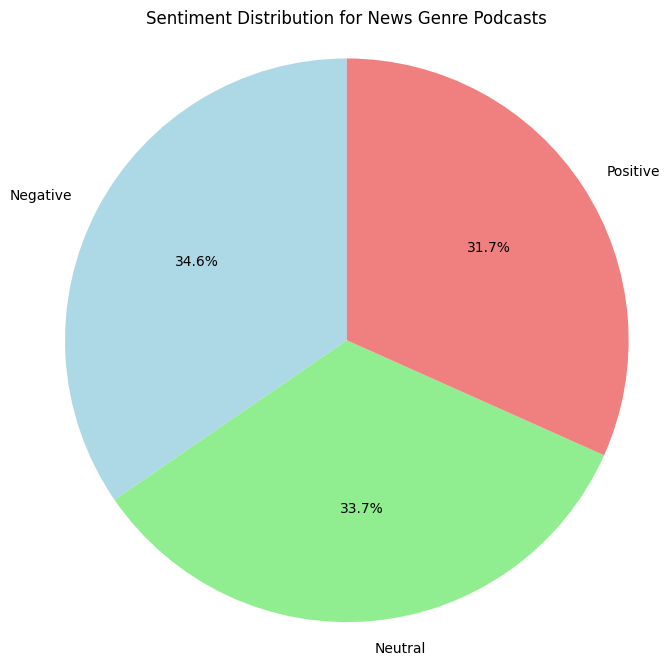

In [27]:

news_podcasts = train[train['Genre'] == 'News']
news_sentiment_counts = news_podcasts['Episode_Sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(news_sentiment_counts, labels=news_sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Sentiment Distribution for News Genre Podcasts')
plt.axis('equal')  
plt.show()


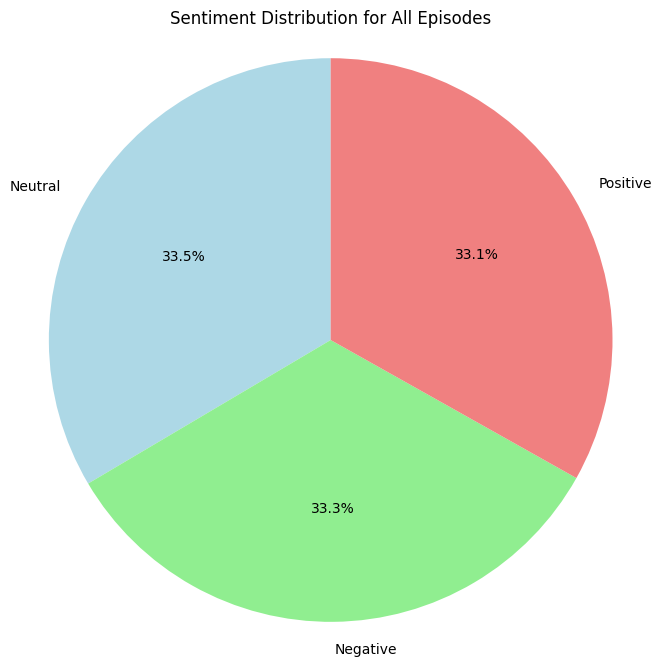

In [28]:

sentiment_counts = train['Episode_Sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Sentiment Distribution for All Episodes')
plt.axis('equal')  
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

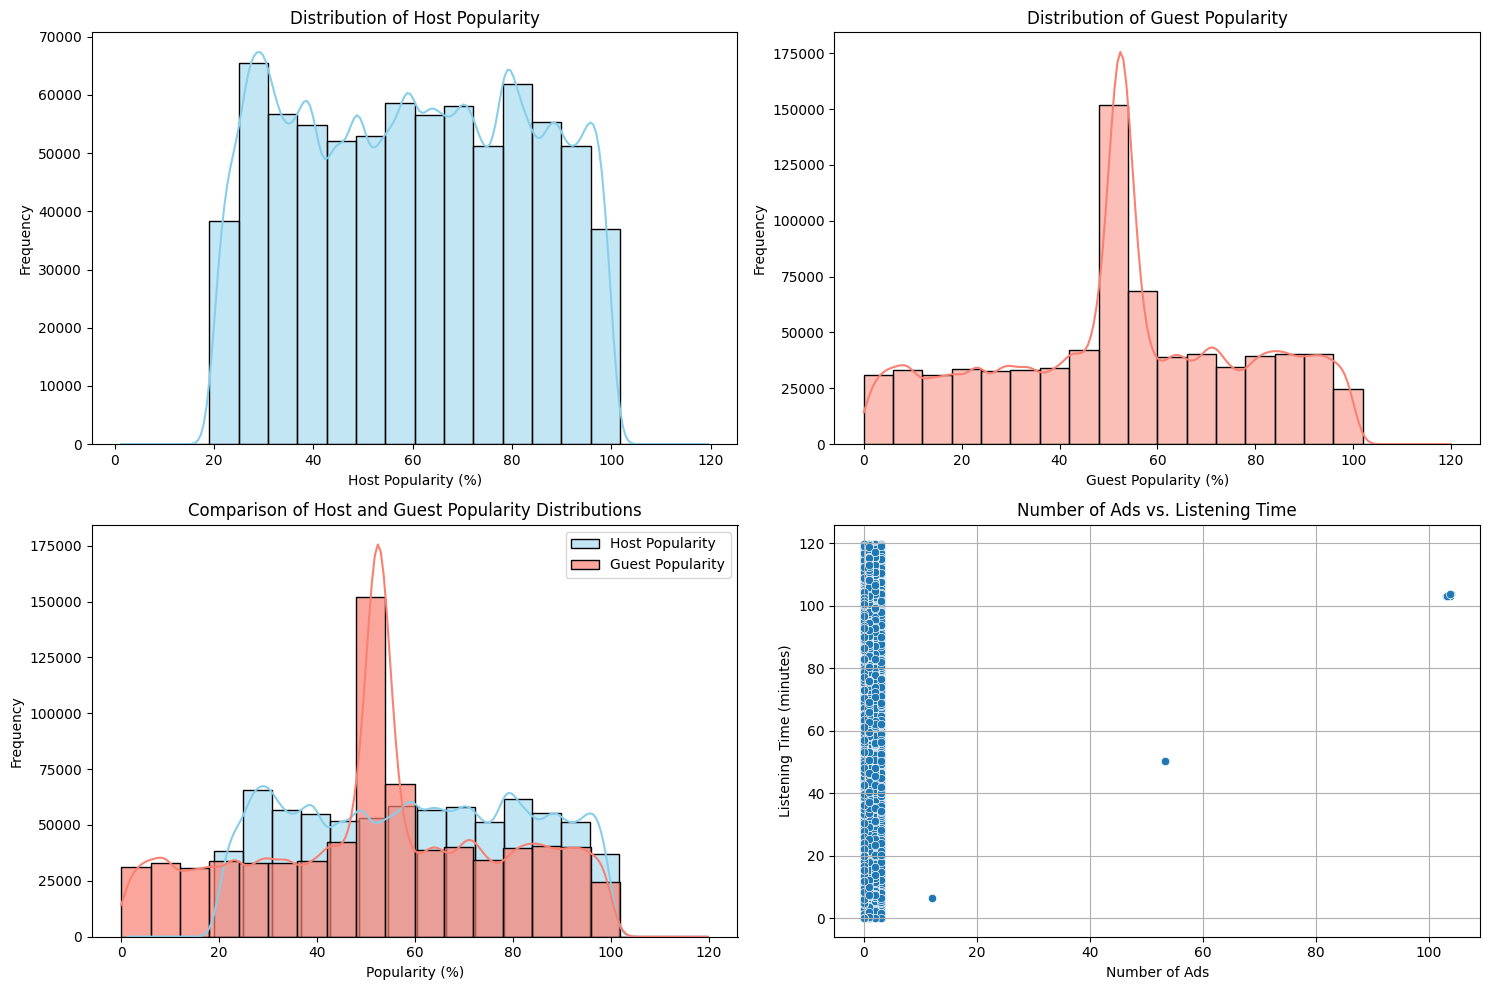

In [29]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1) 
sns.histplot(train['Host_Popularity_percentage'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Host Popularity')
plt.xlabel('Host Popularity (%)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2) 
sns.histplot(train['Guest_Popularity_percentage'], bins=20, kde=True, color='salmon')
plt.title('Distribution of Guest Popularity')
plt.xlabel('Guest Popularity (%)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(train['Host_Popularity_percentage'], bins=20, kde=True, color='skyblue', label='Host Popularity')
sns.histplot(train['Guest_Popularity_percentage'], bins=20, kde=True, color='salmon', alpha=0.7, label='Guest Popularity')
plt.title('Comparison of Host and Guest Popularity Distributions')
plt.xlabel('Popularity (%)')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 4) 
sns.scatterplot(x='Number_of_Ads', y='Listening_Time_minutes', data=train)
plt.title('Number of Ads vs. Listening Time')
plt.xlabel('Number of Ads')
plt.ylabel('Listening Time (minutes)')
plt.grid(True)

plt.tight_layout() 
plt.show()

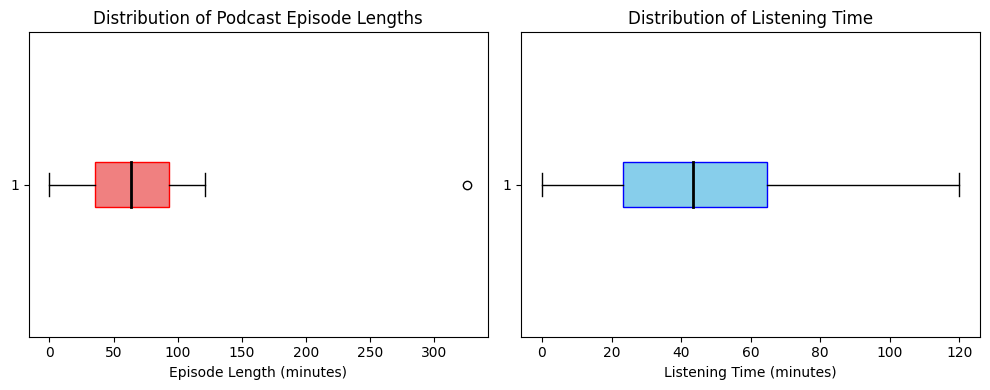

In [30]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.boxplot(train['Episode_Length_minutes'], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightcoral', color='red'), 
            medianprops=dict(color='black', linewidth=2))
plt.title('Distribution of Podcast Episode Lengths')
plt.xlabel('Episode Length (minutes)')


plt.subplot(1, 2, 2)
plt.boxplot(train['Listening_Time_minutes'], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='skyblue', color='blue'), 
            medianprops=dict(color='black', linewidth=2))
plt.title('Distribution of Listening Time')
plt.xlabel('Listening Time (minutes)')

plt.tight_layout()  
plt.show()

<a id = '6'></a>
## Correlation Heatmap

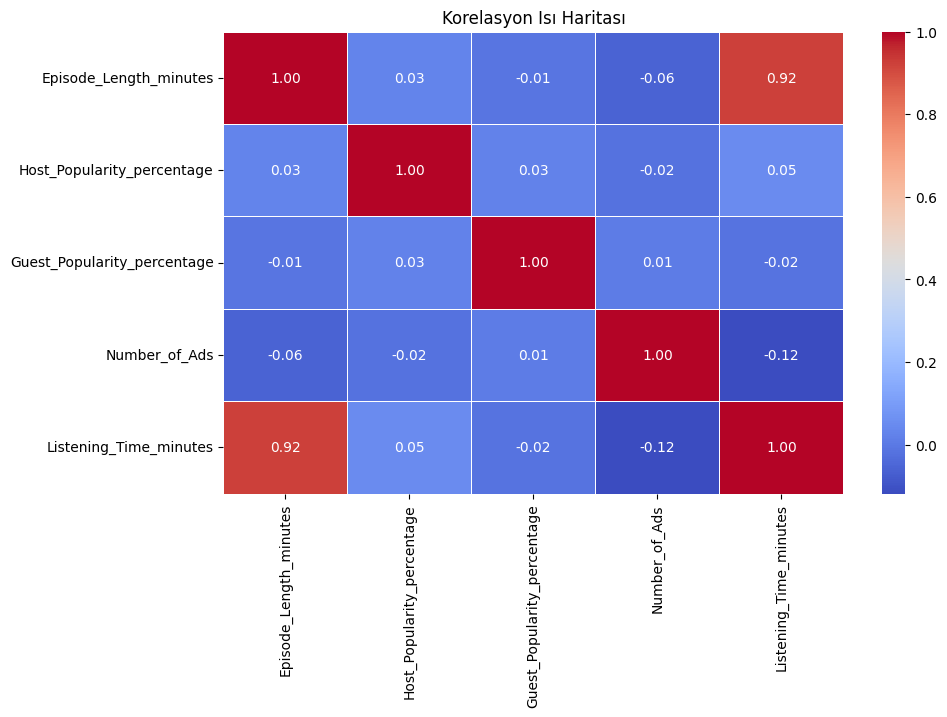

In [31]:
## Corr 
numeric_columns = ["Episode_Length_minutes", "Host_Popularity_percentage", "Guest_Popularity_percentage", "Number_of_Ads", "Listening_Time_minutes"]
train_numeric = train[numeric_columns]

fig, ax = plt.subplots(figsize=(10,6)) 
sns.heatmap(train_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=ax)
plt.title("Korelasyon Isı Haritası")
plt.show()

- **There is a strong positive correlation (+0.92) between Episode_Length_minutes and Listening_Time_minutes.**  
  - As the episode length increases, the listening time also increases. This is an expected result.  

- **There is a slight negative correlation (-0.12) between Number_of_Ads and Listening_Time_minutes.**  
  - As the number of ads increases, the listening time may decrease slightly.  

- **The variables Host_Popularity_percentage and Guest_Popularity_percentage have low correlations with other variables.**  
  - This suggests that a podcast’s popularity does not have a strong direct impact on listening time or other factors.

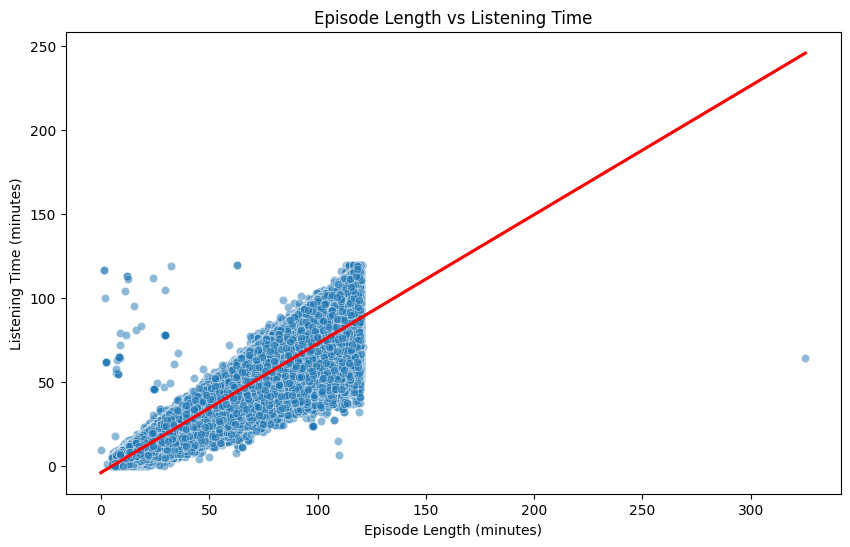

In [32]:
## Let's examine the high correlation between episode length and episode listening time.

plt.figure(figsize=(10,6))
sns.scatterplot(data=train, x="Episode_Length_minutes", y="Listening_Time_minutes", alpha=0.5)

sns.regplot(data=train, x="Episode_Length_minutes", y="Listening_Time_minutes", scatter=False, color="red")

plt.xlabel("Episode Length (minutes)")
plt.ylabel("Listening Time (minutes)")
plt.title("Episode Length vs Listening Time")
plt.show()

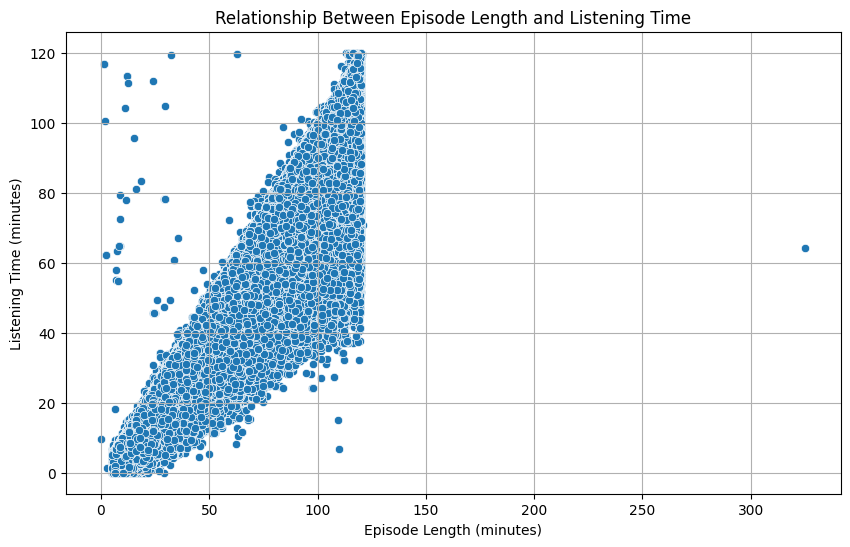

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Episode_Length_minutes', y='Listening_Time_minutes', data=train)
plt.title('Relationship Between Episode Length and Listening Time')
plt.xlabel('Episode Length (minutes)')
plt.ylabel('Listening Time (minutes)')
plt.grid(True) 
plt.show()

When examining the relationship between episode length and listening time, a high correlation is observed between these two variables. The significant concentration of data points in the graph within the 0-120 minute range indicates that both episode lengths and their corresponding listening times frequently fall within this duration. This situation can be interpreted as listeners generally showing more interest in or being more accustomed to content of this length.

However, beyond episode lengths of 120 minutes, a deceleration in the increase of listening times, and even a tendency for decrease in some episodes, becomes apparent. This suggests that there might be a limit to the amount of time listeners are willing to dedicate to very long podcast episodes, or that the likelihood of listening to these longer content pieces in their entirety diminishes.

Naturally, the presence of exceptional episodes that deviate from the general trends should not be overlooked. Factors such as the popularity of these episodes, the quality of the content, the appeal of the guests, or promotional strategies can lead to significant differences in listening times, independent of episode length. Therefore, when creating a successful podcast strategy, it is of great importance to consider both ideal episode lengths that align with listener preferences and to offer high quality and engaging content across all durations.

<a id="7"></a>
## Feature Engineering

<a id="7.1"></a>
### Feature Creation

In [34]:
# Train verisi için Cyclinal Encoding
train['Publication_Day_sin'] = np.sin(2 * np.pi * train['Publication_Day_num'] / 7)
train['Publication_Day_cos'] = np.cos(2 * np.pi * train['Publication_Day_num'] / 7)

train['Publication_Time_sin'] = np.sin(2 * np.pi * train['Publication_Time_num'] / 24)
train['Publication_Time_cos'] = np.cos(2 * np.pi * train['Publication_Time_num'] / 24)

# Test verisi için Cyclinal Encoding
test['Publication_Day_sin'] = np.sin(2 * np.pi * test['Publication_Day_num'] / 7)
test['Publication_Day_cos'] = np.cos(2 * np.pi * test['Publication_Day_num'] / 7)

test['Publication_Time_sin'] = np.sin(2 * np.pi * test['Publication_Time_num'] / 24)
test['Publication_Time_cos'] = np.cos(2 * np.pi * test['Publication_Time_num'] / 24)



In [35]:
# Ad Density
train['Ad_Density'] = train['Number_of_Ads'] / train['Episode_Length_minutes']
test['Ad_Density'] = test['Number_of_Ads'] / test['Episode_Length_minutes']

# Popularity Interaction
train['Popularity_Interaction'] = train['Host_Popularity_percentage'] * train['Guest_Popularity_percentage']
test['Popularity_Interaction'] = test['Host_Popularity_percentage'] * test['Guest_Popularity_percentage']

# Popularity Difference
train['Popularity_Difference'] = train['Host_Popularity_percentage'] - train['Guest_Popularity_percentage']
test['Popularity_Difference'] = test['Host_Popularity_percentage'] - test['Guest_Popularity_percentage']

# Weekday vs Weekend
train['Is_Weekend'] = train['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)
test['Is_Weekend'] = test['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)

# Interaction Features
train['Ad_Length_Interaction'] = train['Number_of_Ads'] * train['Episode_Length_minutes']
test['Ad_Length_Interaction'] = test['Number_of_Ads'] * test['Episode_Length_minutes']

train['Host_Ads_Interaction'] = train['Host_Popularity_percentage'] * train['Number_of_Ads']
test['Host_Ads_Interaction'] = test['Host_Popularity_percentage'] * test['Number_of_Ads']


<a id="7.2"></a>
### Feature Scaling

In [36]:
# Modelde kullanmayacağımız sütunlar
drop_columns = ["id", "Podcast_Name", "Episode_Title"]
existing_drop_cols = [col for col in drop_columns if col in train.columns]

# Hedef değişken
target = "Listening_Time_minutes"

# Sayısal sütunları seç (hedef ve drop sütunları hariç)
numerical_cols = train.select_dtypes(include=["int64", "float64"]).drop(columns=existing_drop_cols + [target], errors="ignore").columns.tolist()

# Sayısal verileri al ve ölçekle
scaler = StandardScaler()
X_numeric = scaler.fit_transform(train[numerical_cols])

In [37]:
# Kategorik sütunları seç
categorical_cols = train.select_dtypes(include=["object"]).columns.tolist()

# One-Hot Encoding işlemi
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
X_categorical = encoder.fit_transform(train[categorical_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [52]:
# Tüm özellikleri birleştir
X_processed = np.concatenate([X_numeric, X_categorical], axis=1)

# Hedef değişken
y = train[target].values

print(f"Final feature shape: {X_processed.shape}")

Final feature shape: (750000, 189)


In [39]:
# Sayısal sütun isimleri zaten elimizde
numeric_feature_names = numerical_cols

# One-Hot Encoder'dan çıkan kategorik sütun isimlerini al
categorical_feature_names = encoder.get_feature_names_out(categorical_cols).tolist()

# Tüm sütun adlarını birleştir
all_feature_names = numeric_feature_names + categorical_feature_names

X_train = pd.DataFrame(X_processed, columns=all_feature_names)

# Gerekirse kontrol et
X_train.head()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Publication_Day_num,Publication_Time_num,Episode_Sentiment_num,Publication_Day_sin,Publication_Day_cos,Publication_Time_sin,...,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Episode_Sentiment_Negative,Episode_Sentiment_Neutral,Episode_Sentiment_Positive
0,-0.493586,0.653611,0.062109,-1.171767,-0.015219,1.241732,1.228823,0.637914,-1.281682,0.021760,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.703333,0.309976,0.928659,0.565658,0.972829,-0.472654,-1.223843,-1.363503,-0.326218,-0.377123,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.297575,0.442009,-1.692349,-1.171767,-1.003266,0.479783,-1.223843,1.132223,0.865225,-1.147706,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.091459,-0.115415,1.036270,0.565658,-1.497289,-1.425091,1.228823,0.021520,1.395468,1.619279,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.418813,0.883576,0.252863,1.434371,-1.497289,-0.472654,0.002490,0.021520,1.395468,-0.377123,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
# Test verisindeki sayısal sütunları aynı scaler ile dönüştür
X_test_scaled = scaler.transform(test[numerical_cols])

In [41]:
# Test verisindeki kategorik sütunları dönüştür
X_test_encoded = encoder.transform(test[categorical_cols])

In [42]:
# Scaled + Encoded birleşimi
X_test_processed = np.hstack([X_test_scaled, X_test_encoded])

# DataFrame oluştur
X_test = pd.DataFrame(X_test_processed, columns=all_feature_names)

# Kontrol
X_test.head()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Publication_Day_num,Publication_Time_num,Episode_Sentiment_num,Publication_Day_sin,Publication_Day_cos,Publication_Time_sin,...,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Episode_Sentiment_Negative,Episode_Sentiment_Neutral,Episode_Sentiment_Positive
0,0.452545,-0.950895,0.043511,-0.303054,0.972829,0.479783,0.002490,-1.363503,-0.326218,-1.147706,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-1.112164,0.499718,-0.029551,-1.171767,1.466852,-1.425091,0.002490,-1.089182,0.865225,1.619279,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.150568,0.351072,1.772328,-1.171767,0.478805,0.479783,1.228823,-0.594873,-1.281682,-1.147706,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.568270,-1.594009,-0.018316,0.565658,1.466852,-1.425091,1.228823,-1.089182,0.865225,1.619279,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.249185,-0.076942,-1.601173,0.565658,-0.509242,-1.425091,0.002490,1.406544,-0.326218,1.619279,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


<a id = '8'></a>
## Modeling

<a id ='8.1'></a>
### Linear Regression

In [43]:
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

In [44]:
lreg = LinearRegression()

In [45]:
scores = cross_val_score(lreg, X_train, y, cv = 5, scoring = 'neg_root_mean_squared_error')
rmse_score = np.abs(scores)
print(f"Mean AUC: {rmse_score.mean():.4f}")

Mean AUC: 10.1710


In [46]:
lreg.fit(X_train , y)
y_test_pred = lreg.predict(X_test)

In [47]:
submission = pd.DataFrame({
    "id": test["id"],
    "rainfall": y_test_pred
})

submission.to_csv("submission_linear_regresion.csv", index=False)

<a id ='8.2'></a>
### XGBoost Modeling

Best Parameters: {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}
Best RMSE: 9.54224163381688

In [48]:
xgb_model = XGBRegressor(subsample = 0.6,reg_lambda = 1.0,reg_alpha = 0, n_estimators =500 , max_depth = 15, 
                        learning_rate = 0.05,gamma = 0.5,colsample_bytree = 1.0)

In [49]:
scores = cross_val_score(xgb_model, X_train, y, cv = 5, scoring = 'neg_root_mean_squared_error')
rmse_score = np.abs(scores)
print(f"Mean AUC: {rmse_score.mean():.4f}")

Mean AUC: 9.4842


In [50]:
xgb_model.fit(X_train,y)
y_pred = xgb_model.predict(X_test)

In [51]:
submission = pd.DataFrame({
    "id": test["id"],
    "rainfall": y_pred
})

submission.to_csv("submission_xgb_regresion.csv", index=False)

<a id = '8.3'></a>
### LightGBM Modeling

In [ ]:
# LightGBM modeling
lgbm_model = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=15,
    subsample=0.7,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

In [ ]:
lgbm_scores = cross_val_score(
    lgbm_model,
    X_train,
    y,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

In [ ]:
rmse_scores = np.abs(lgbm_scores)
print(f"LightGBM CV RMSE Scores: {rmse_scores}")
print(f"LightGBM Mean RMSE: {rmse_scores.mean():.4f}")

In [ ]:
lgbm_model.fit(X_train, y)

In [ ]:
lgbm_pred = lgbm_model.predict(X_test)

In [ ]:
submission = pd.DataFrame({
    "id": test["id"],
    "Listening_Time_minutes": lgbm_pred
})
submission.to_csv("submission_lgbm.csv", index=False)